# WMT Budget 
## (using ERA5 | GLORYS | MATT's model)

In [ ]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram

In [ ]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
#mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
heat_fluxes = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})
glorys = xr.open_dataset('sst_glorys.nc', chunks={})

In [ ]:
heat_fluxes

In [ ]:
glorys

# 1) Process budget variables 
(to desired spatial/grid and temporal configuration)

In [3]:
time_slice = dict(time=slice('1993', '2021-06-30'))
gom = dict(longitude=slice(-98, -81), latitude=slice(17.5, 31))

sst_g = glorys.thetao.sel(**gom)
sst = sst_ds.sea_surface_temperature.sel(**time_slice).resample(time='D').mean()
#mask = mask_ds.land_sea_mask

sw = heat_fluxes.ssr.sel(**time_slice) / (60*60) #W/m2
lw = heat_fluxes.str.sel(**time_slice) / (60*60) #W/m2
sh = heat_fluxes.sshf.sel(**time_slice) / (60*60) #W/m2
lh = heat_fluxes.slhf.sel(**time_slice) / (60*60) #W/m2

In [6]:
sst

<xarray.DataArray 'sea_surface_temperature' (time: 10408, latitude: 55,
                                             longitude: 69)> Size: 158MB
dask.array<transpose, shape=(10408, 55, 69), dtype=float32, chunksize=(10408, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [7]:
sst_g

<xarray.DataArray 'thetao' (time: 10408, depth: 49, latitude: 163,
                            longitude: 205)> Size: 136GB
dask.array<getitem, shape=(10408, 49, 163, 205), dtype=float64, chunksize=(10408, 49, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Attributes:
    long_name:      Temperature
    unit_long:      Degrees Celsius
    standard_name:  sea_water_potential_temperature
    valid_min:      -32766
    valid_max:      21306
    units:          degrees_C

In [8]:
#daily clim
clim = sst.groupby('time.dayofyear').mean('time')
clim_g = sst_g.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst.groupby('time.dayofyear') - clim
anom_g = sst_g.groupby('time.dayofyear') - clim_g

#monthly clim
mo_clim = sst.groupby('time.month').mean('time')
mo_clim_g = sst_g.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst.groupby('time.month') - mo_clim
mo_anom = sst_g.groupby('time.month') - mo_clim_g

In [9]:
# Find 90th, 95th, 99th percentile temperatures
q99 = sst.quantile(0.99, dim='time')
q95 = sst.quantile(0.95, dim='time')
q90 = sst.quantile(0.90, dim='time')

q99_g = sst_g.isel(depth=0).quantile(0.99, dim='time')
q95_g = sst_g.isel(depth=0).quantile(0.95, dim='time')
q90_g = sst_g.isel(depth=0).quantile(0.90, dim='time')

In [10]:
mask = sst[0].isnull()
mask_g = sst_g[0,0].isnull()

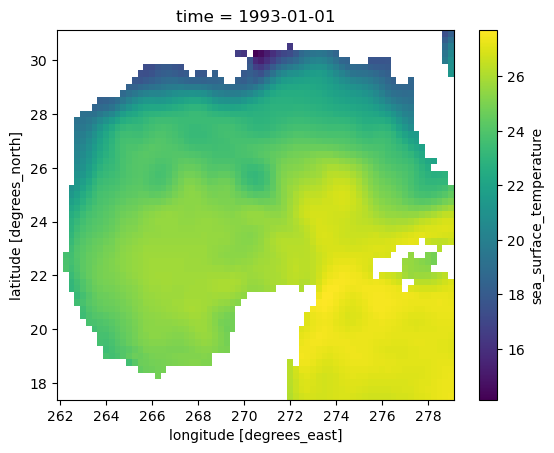

In [11]:
sst[0].where(~mask).plot()

In [12]:
q90_g

<xarray.DataArray 'thetao' (latitude: 163, longitude: 205)> Size: 267kB
dask.array<getitem, shape=(163, 205), dtype=float64, chunksize=(163, 205), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
    quantile   float64 8B 0.9

In [13]:
mask_g

<xarray.DataArray 'thetao' (latitude: 163, longitude: 205)> Size: 33kB
dask.array<isnan, shape=(163, 205), dtype=bool, chunksize=(163, 205), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 4B 0.494
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
    time       datetime64[ns] 8B 1993-01-01

In [14]:
# Define isotherm values to represent the MHW
isotherm = 29.4

# 2) Compute LHS ($\frac{\partial V}{\partial t}$)
(but not really dVdt)

## Create grid and area objects

### GLORYS

In [15]:
ds_pt_full = generate_grid_ds(glorys.sel(**gom), {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [16]:
ds_pt_full

<xarray.Dataset> Size: 136GB
Dimensions:         (depth: 49, latitude: 163, longitude: 205, time: 10408,
                     longitude_left: 205, latitude_left: 163)
Coordinates:
  * depth           (depth) float32 196B 0.494 1.541 ... 4.833e+03 5.275e+03
  * latitude        (latitude) float32 652B 17.5 17.58 17.67 ... 30.92 31.0
  * longitude       (longitude) float32 820B -98.0 -97.92 ... -81.08 -81.0
  * time            (time) datetime64[ns] 83kB 1993-01-01 ... 2021-06-30
  * longitude_left  (longitude_left) float32 820B -98.04 -97.96 ... -81.04
  * latitude_left   (latitude_left) float32 652B 17.46 17.54 ... 30.88 30.96
Data variables:
    thetao          (time, depth, latitude, longitude) float64 136GB dask.array<chunksize=(10408, 49, 163, 205), meta=np.ndarray>
Attributes:
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    source:       MERCATOR GLORYS12V1
    Conventions:  CF-1.4
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:   http://www.mercator-ocean.fr
    institution:  MERCATOR OCEAN

In [17]:
grid_pt_full

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Z Axis (not periodic, boundary=None):
  * center   depth
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center

In [18]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [19]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


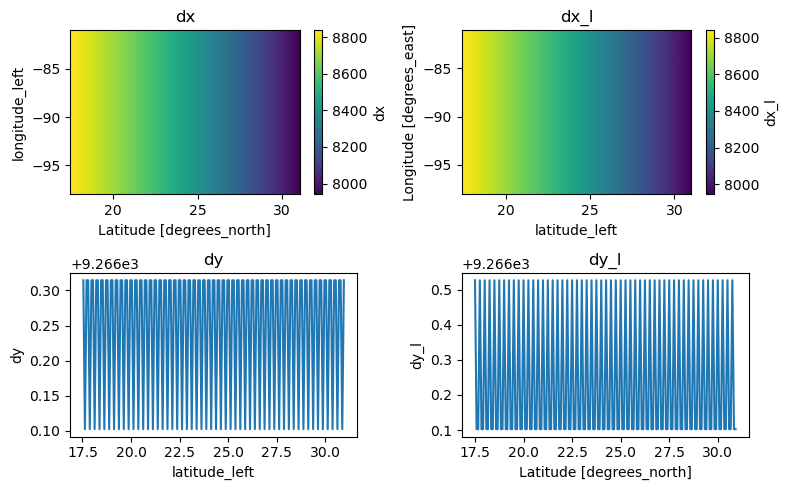

In [20]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

### `dVdt` using `.where(thetao>=isotherm)`

In [59]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = sst_g.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
masked_vol = vol.where(sst_g[:,1:,:,:-1]>=isotherm) #m^3
vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
M = vol_tot * 1034 #kg
V = M / 1034 #m^3

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [23]:
V.load()

<xarray.DataArray (time: 10408)> Size: 42kB
array([5.9195208e+09, 4.4315489e+09, 4.4315489e+09, ..., 1.8408918e+12,
       1.1588846e+12, 8.7037732e+11], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [60]:
dt_values = (np.diff(V.time)/1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], coords={'time':(['time'], V.time.values[1:])})

dVdt = V.diff('time', label='upper') / dt #m^3/s

In [25]:
dVdt

<xarray.DataArray (time: 10407)> Size: 42kB
array([  -17221.896,        0.   ,        0.   , ..., -2794679.5  ,
       -7893602.   , -3339204.8  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 83kB 1993-01-02 1993-01-03 ... 2021-06-30

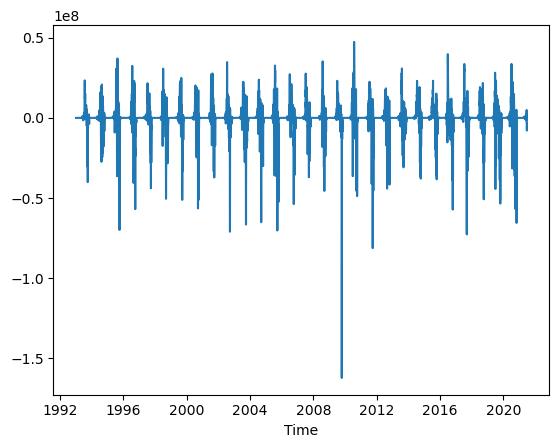

In [26]:
dVdt.plot()

### `dVdt` using `histogram(thetao, weights=vol)`

In [27]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')

dz = sst_g.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
#masked_vol = vol.where(gopaf_pottemp.thetao[:, 1:, :, :-1]>=31.8) #m^3
#vol_tot = masked_vol.sum(['latitude', 'longitude', 'depth']) #m^3
#M = vol_tot * 1034 #kg
#V = M / 1034 #m^3

#expanded tbin range to include colder temps because cumsum method wasn't matching with other dvdt definitions
delta_theta = 0.1
theta_bins = np.arange(20, 38, delta_theta)

tdist = histogram(sst_g[:,1:,:,:-1].rename('theta'), bins=[theta_bins],
                  weights=vol, dim=['latitude', 'longitude', 'depth']) #˚C m^3

V = tdist.isel(theta_bin=slice(None, None, -1)).cumsum(dim='theta_bin')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [31]:
V.load()

<xarray.DataArray 'histogram_theta' (time: 10408, theta_bin: 339)> Size: 14MB
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2872700e+15,
        3.2872700e+15, 3.2872700e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2873183e+15,
        3.2873183e+15, 3.2873183e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2874437e+15,
        3.2874437e+15, 3.2874437e+15],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2866316e+15,
        3.2866316e+15, 3.2866316e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2826771e+15,
        3.2826771e+15, 3.2826771e+15],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.2835650e+15,
        3.2835650e+15, 3.2835650e+15]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * theta_bin  (theta_bin) float64 3kB 33.85 33.75 33.65 ... 0.25 0.15 0.05

In [32]:
tdist

<xarray.DataArray 'histogram_theta' (time: 10408, theta_bin: 339)> Size: 14MB
dask.array<sum-aggregate, shape=(10408, 339), dtype=float32, chunksize=(10408, 339), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * theta_bin  (theta_bin) float64 3kB 0.05 0.15 0.25 0.35 ... 33.65 33.75 33.85

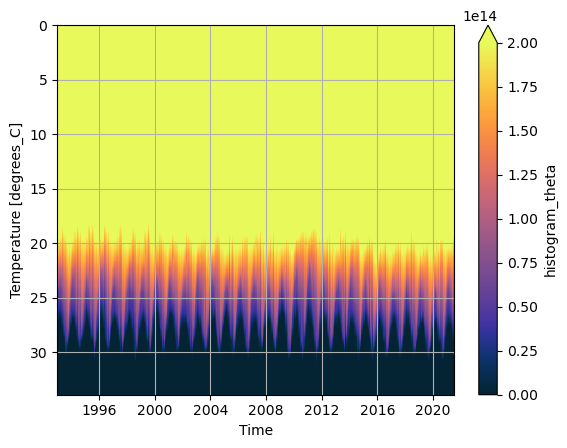

In [33]:
V.transpose().plot(yincrease=False, robust=True, cmap=cmocean.cm.thermal, vmax=2e14)
plt.grid();

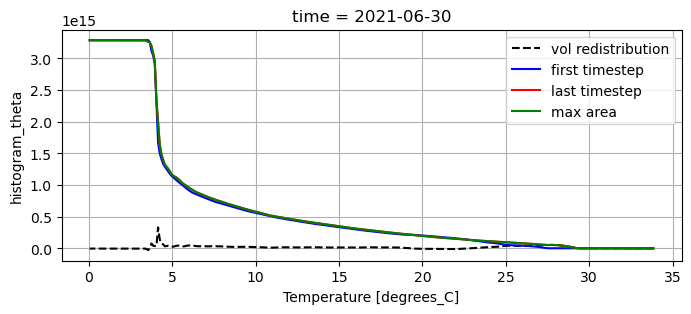

In [34]:
plt.figure(figsize=(8,3))
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
V[0].plot(label='first timestep', color='b')
V[-1].plot(label='last timestep', color='r')
V.sel(time='2023-08-15', method='nearest').plot(label='max area', color='green')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

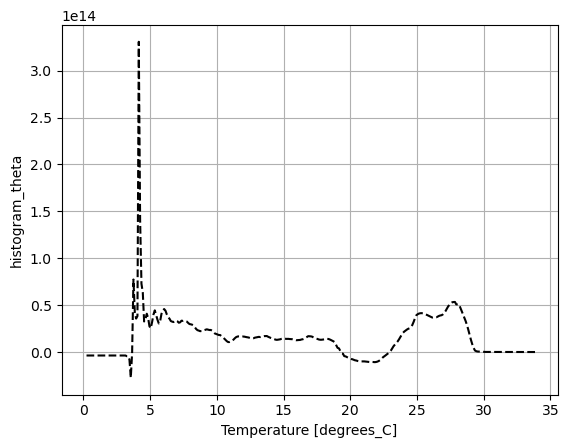

In [35]:
(V[-1] - V[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
plt.grid();

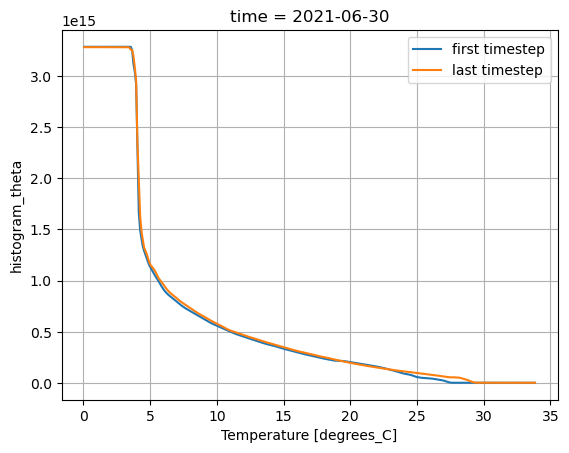

In [36]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.grid();

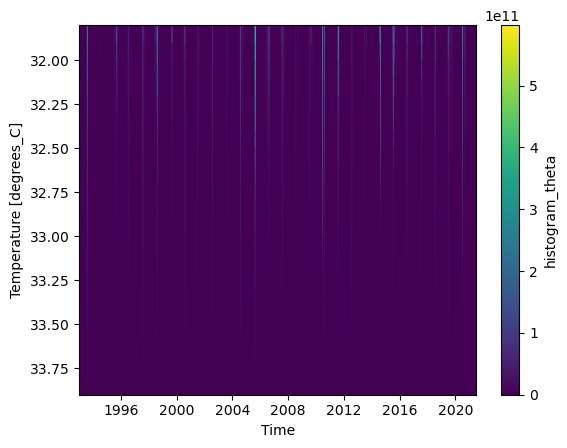

In [37]:
V.sel(theta_bin=slice(None, 31.8)).T.plot(yincrease=False)

In [38]:
delta_V = V.diff(dim='time')
dVdt = delta_V / 86400

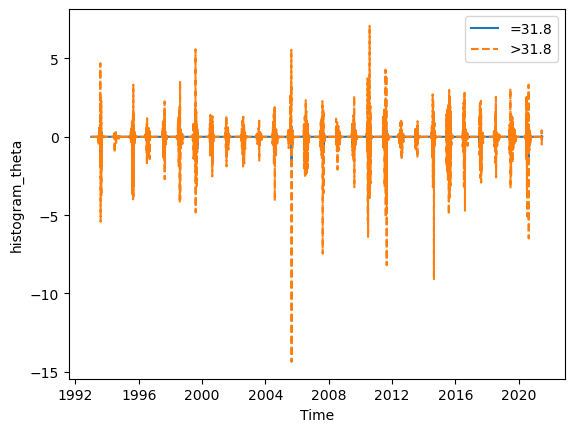

In [39]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='=31.8')
(dVdt/1e6).sel(theta_bin=slice(None, 31.8)).sum('theta_bin').plot(label='>31.8', linestyle='dashed')
plt.legend();

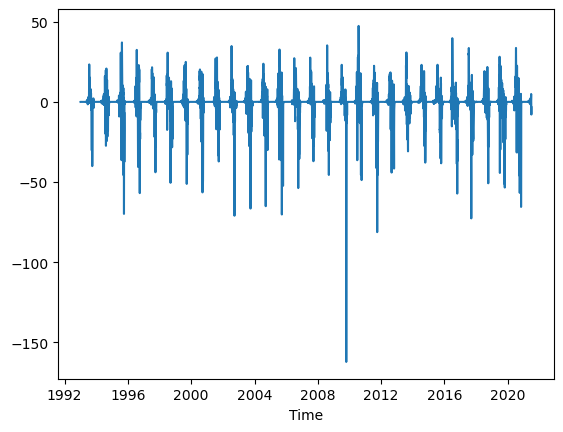

In [61]:
(dVdt/1e6).plot()

In [56]:
#Just checking (5_... nb)
V32 = tdist.sel(theta_bin=slice(31.8, None)).sum('theta_bin')

delta_V32 = V32.diff(dim='time')
dVdt32 = delta_V32 / 86400

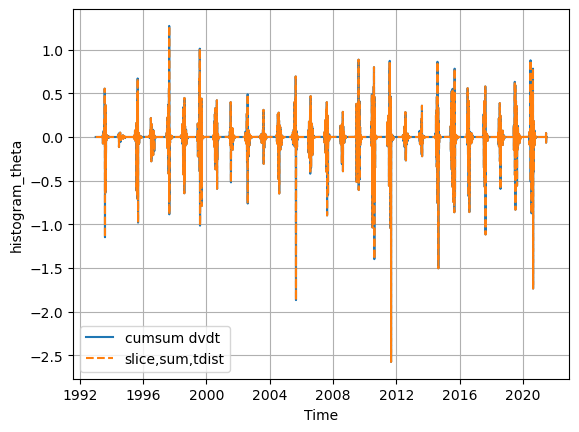

In [41]:
(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='cumsum dvdt')
(dVdt32/1e6).plot(label='slice,sum,tdist', linestyle='dashed')
plt.legend()
plt.grid()

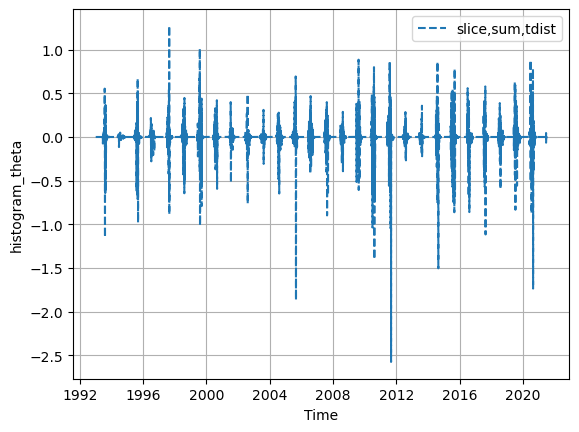

In [57]:
#(dVdt/1e6).sel(theta_bin=31.8, method='nearest').plot(label='cumsum dvdt')
(dVdt32/1e6).plot(label='slice,sum,tdist', linestyle='dashed')
plt.legend()
plt.grid()

In [47]:
dVdt.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/dVdt_hist_method.nc')

In [62]:
dVdt.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/dVdt_where_method.nc')

In [58]:
dVdt32.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/dVdt32_hist_method.nc')

# 3) Compute RHS ($G_\Omega(\theta)$)
- where $\Omega$ is the surface boundary of the WWM of the MHW event in $\theta$ space
- where $G$ is the temperature tendencies due to surface heat fluxes
- surface terms come from ERA5

## Create grid and area objects

In [8]:
#daily clim
clim = sst.groupby('time.dayofyear').mean('time')
clim_g = sst_g.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst.groupby('time.dayofyear') - clim
anom_g = sst_g.groupby('time.dayofyear') - clim_g

#monthly clim
mo_clim = sst.groupby('time.month').mean('time')
mo_clim_g = sst_g.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst.groupby('time.month') - mo_clim
mo_anom = sst_g.groupby('time.month') - mo_clim_g

In [4]:
ds_full_e = generate_grid_ds(heat_fluxes, {'X':'longitude', 'Y':'latitude'})
#ds_full_m = generate_grid_ds(merra, {'X':'lon', 'Y':'lat'})

grid_e = xgcm.Grid(ds_full_e, periodic='X')
#grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [5]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [6]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'latitude', 'longitude')
#cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


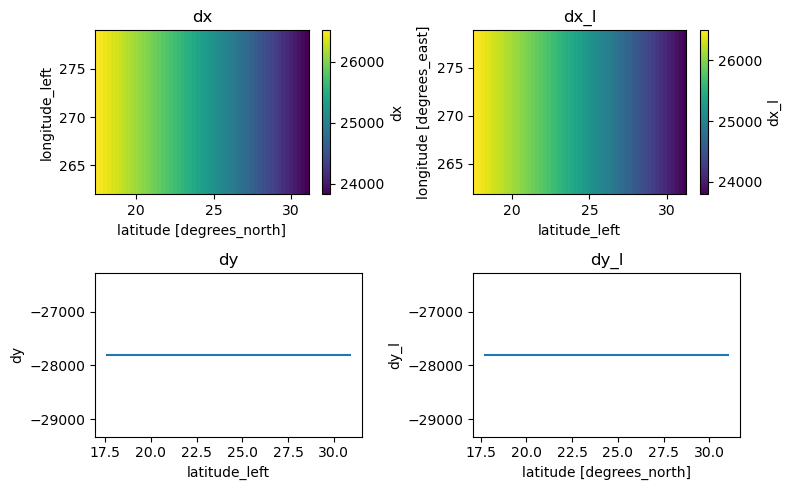

In [11]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

#### Create mask

In [13]:
mask_e = sst[0].isnull()
#mask_m = merra.TSKINWTR[0].isnull()

In [18]:
dx_interp_e.coords

Coordinates:
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5

In [19]:
cell_elements_e.dy_l.coords

Coordinates:
  * latitude  (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5

In [14]:
dx_interp_e = grid_e.interp(cell_elements_e.dx_l, 'Y')
area_e = dx_interp_e * cell_elements_e.dy_l

#dx_interp_m = grid_m.interp(cell_elements_m.dx_l, 'Y')
#area_m = dx_interp_m * cell_elements_m.dy_l

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [21]:
area_e.coords

Coordinates:
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5

In [22]:
heat_fluxes.coords

Coordinates:
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [23]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027 #kg/m^3 #according to Harte Research Institute(https://www.harteresearch.org/sites/default/files/inline-files/3.pdf)

#(W/m^2) x 1/Cp x 1/rho x area
era_weighted = (heat_fluxes * area_e * (1/Cp) * (1/rho)) #˚C m^3/s
#merra_weighted = (merra.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                 # area_m.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s

$$F_{PS77} = Re^{- \frac{z}{h_1}} + (1-R)e^{- \frac{z}{h_2}}$$
where $R = 0.58$, $h_1 = 0.35$ m, $h_2 = 0.23$ m (eq from Groeskamp and Iudicone 2018 GRL)

In [27]:
glorys.depth.values

array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03], dtype=float32)

In [28]:
#Create decay function for SSR penetration
#Jerlov Type 1 (upper 50m)
R = 0.68
h1 = 1.2 #m
h2 = 28 #m
z_values = np.array([0, 4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03])
z = xr.DataArray(data=z_values, dims={'depth'}, coords={'depth':z_values})
F_ps77 = R * np.exp(-z/h1) + (1-R) * np.exp(-z/h2)

#expand ssr da in z dimension then apply decay function 
ssr_Zexpanded = era_weighted.ssr.expand_dims({'depth':z}) 
ssr_z = ssr_Zexpanded * (F_ps77)

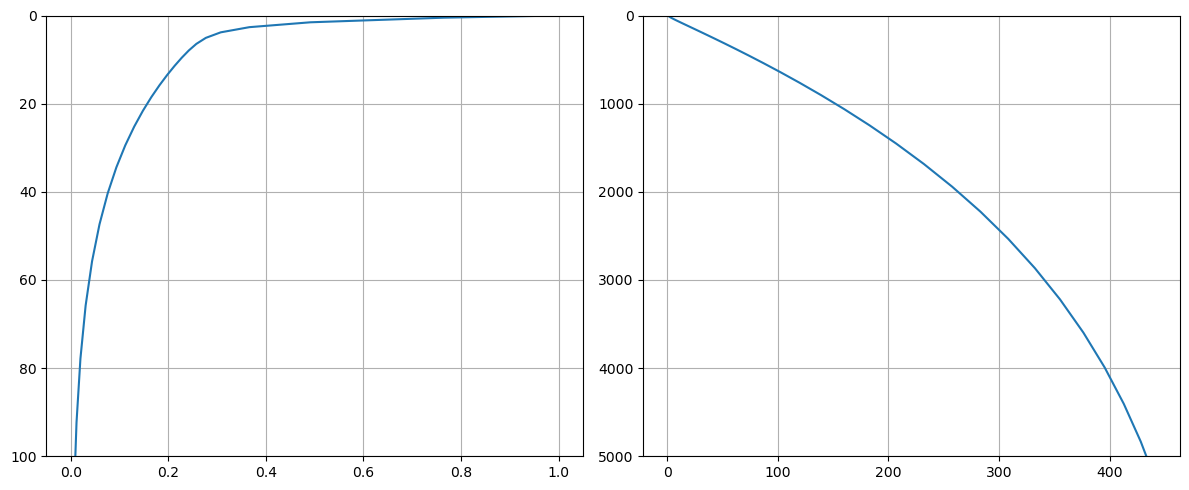

In [29]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(F_ps77, z)
ax0.set_ylim(100, 0)
ax0.grid()

ax1.plot(z.diff(dim='depth'), z.diff(dim='depth').depth)
ax1.set_ylim(5000,0)
#ax1.set_xlim(0, None)
ax1.grid()

plt.tight_layout();

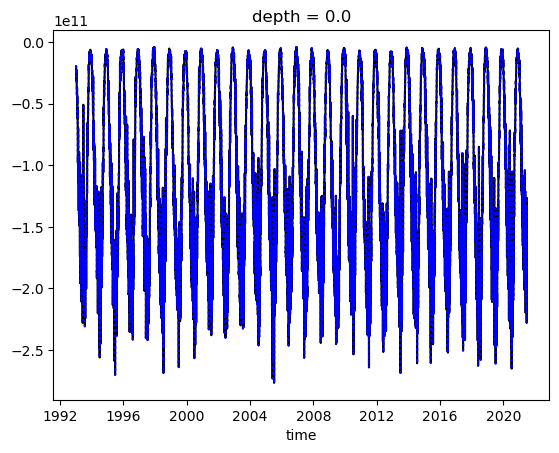

In [34]:
era_weighted.ssr.sum(['latitude', 'longitude']).plot(color='k')
ssr_z.sum(['latitude', 'longitude']).isel(depth=0).plot(color='blue', linestyle='dotted')

In [35]:
dFlx = ssr_z.diff(dim='depth')
dz = z.diff(dim='depth')
dFlxdz = - dFlx / dz

In [37]:
dFlxdz

<xarray.DataArray (depth: 49, time: 10408, latitude: 55, longitude: 69)> Size: 15GB
dask.array<truediv, shape=(49, 10408, 55, 69), dtype=float64, chunksize=(49, 10408, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

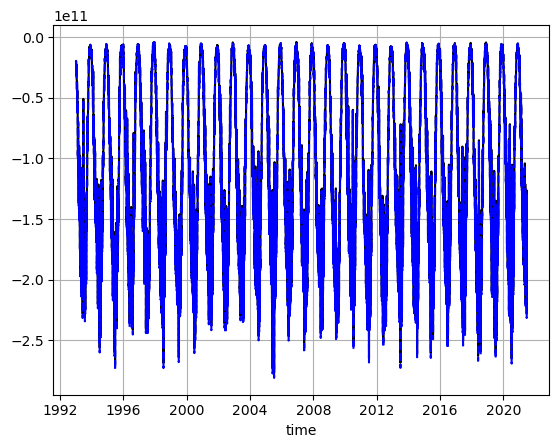

In [36]:
era_weighted.ssr.sum(['latitude', 'longitude']).plot(color='k')
dFlxdz.sum(['latitude', 'longitude', 'depth']).plot(color='blue', linestyle='--')
plt.grid()

In [38]:
sst_g.shape

(10408, 49, 163, 205)

In [39]:
dFlxdz.transpose('time', 'depth', 'latitude', 'longitude').shape

(10408, 49, 55, 69)

In [45]:
delta_theta = 0.1
theta_bins = np.arange(20, 38, delta_theta)

def hist_func(sst, ds, lat, lon, variable):
    hist = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=ds[variable].fillna(0.),
                    dim=[lon, lat]) / delta_theta
    return hist #m^3/s (Sv)

def hist_func_ssrz(sst, da, lat, lon, depth):
    hist_srp = histogram(sst.rename('theta'), bins=[theta_bins],
                    weights=da.fillna(0.),
                    dim=[lon, lat, depth]) / delta_theta
    return hist_srp #m^3/s (Sv)


In [51]:
list(era_weighted.data_vars)[1:]

['str', 'sshf', 'slhf']

In [53]:
era_hist = xr.merge([hist_func(sst, 
                               era_weighted.where(~mask_e),
                               'latitude', 'longitude', var).rename('omega_'+var) 
                     for var in list(era_weighted)[1:]])
#sst_m = merra.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1)).where(~mask_m)
#merra_hist = xr.merge([hist_func(sst_m, 
#                                 merra_weighted.where(~mask_m),
#                                 'lat', 'lon', var).rename('omega_'+var)
#                      for var in list(merra_weighted)[:-1]])

In [66]:
ssrz_hist = hist_func_ssrz(sst.expand_dims({'depth':dFlxdz.depth}),
                     dFlxdz.transpose('time', 'depth', 'latitude', 'longitude').where(~mask_e),
                     'latitude', 'longitude', 'depth').rename('omega_ssrz')

In [67]:
#merge new ssr da into era_hist and run clim calculations for uploading new clim datasets for fig 3 in manuscript
era_hist['omega_ssrz'] = ssrz_hist

In [69]:
era_hist

<xarray.Dataset> Size: 60MB
Dimensions:     (time: 10408, theta_bin: 179)
Coordinates:
  * time        (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * theta_bin   (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.65 37.75 37.85
Data variables:
    omega_str   (time, theta_bin) float64 15MB dask.array<chunksize=(10408, 179), meta=np.ndarray>
    omega_sshf  (time, theta_bin) float64 15MB dask.array<chunksize=(10408, 179), meta=np.ndarray>
    omega_slhf  (time, theta_bin) float64 15MB dask.array<chunksize=(10408, 179), meta=np.ndarray>
    omega_ssrz  (time, theta_bin) float64 15MB dask.array<chunksize=(10408, 179), meta=np.ndarray>

<Figure size 2500x500 with 0 Axes>

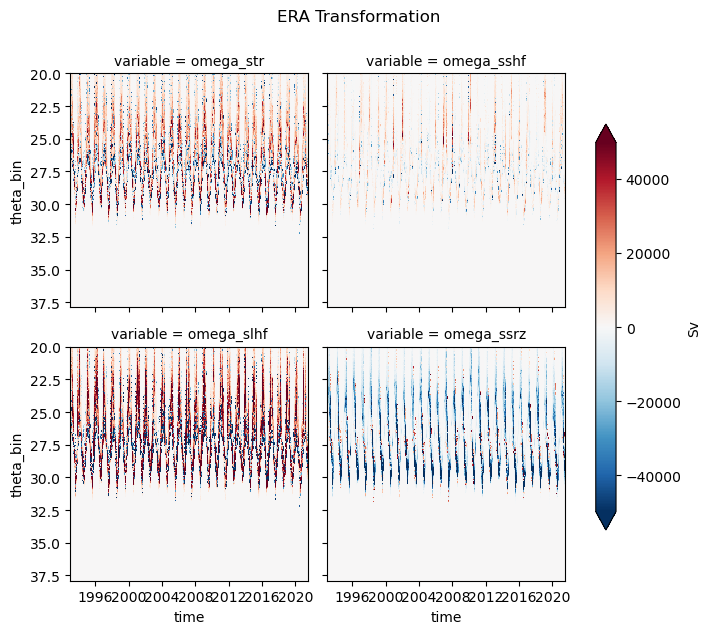

In [68]:
plt.figure(figsize=(25,5))
(era_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('ERA Transformation', y=1.05);

### Save histogram ds

In [70]:
%pwd

'/work5/stb/MHW-gfdl'

In [71]:
era_hist.to_netcdf('/work5/stb/MHW-gfdl/budget-terms/era_hist.nc')

# 4) Budget!

In [75]:
dVdt = xr.open_dataset('budget-terms/dVdt_hist_method.nc')
era_hist = xr.open_dataset('budget-terms/era_hist.nc')

In [101]:
lhs = dVdt.sel(theta_bin=slice(34,20))
rhs = era_hist.sel(theta_bin=slice(20, 34.9))

In [102]:
lhs

<xarray.Dataset> Size: 6MB
Dimensions:          (time: 10407, theta_bin: 139)
Coordinates:
  * time             (time) datetime64[ns] 83kB 1993-01-02 ... 2021-06-30
  * theta_bin        (theta_bin) float64 1kB 33.85 33.75 33.65 ... 20.15 20.05
Data variables:
    histogram_theta  (time, theta_bin) float32 6MB ...

In [103]:
rhs

<xarray.Dataset> Size: 50MB
Dimensions:     (time: 10408, theta_bin: 149)
Coordinates:
  * time        (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * theta_bin   (theta_bin) float64 1kB 20.05 20.15 20.25 ... 34.65 34.75 34.85
Data variables:
    omega_str   (time, theta_bin) float64 12MB ...
    omega_sshf  (time, theta_bin) float64 12MB ...
    omega_slhf  (time, theta_bin) float64 12MB ...
    omega_ssrz  (time, theta_bin) float64 12MB ...